# Using netMHC predictions

In [4]:
import glob, json
import numpy as np
import pandas as pd
from scipy.stats import entropy
import sklearn.decomposition
import sklearn.manifold
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('..')

from lib import *
from IPython.display import display, HTML
import weblogo
#from corebio.seq import SeqList, Alphabet

In [5]:
dfbinders = pd.concat(pd.read_csv(filename, sep=',') for filename in glob.glob(datadir + 'netmhc/Malaria-HLA-*.csv.gz'))

In [6]:
totalpeptides = sum(len(seq) for h, seq in fasta_iter(human))
totalpeptides

11518487

In [7]:
counter9 = count_kmers_proteome(proteome_path('Malaria'), 9)

In [8]:
len(counter9)

3811104

In [9]:
len(dfbinders['Peptide'].unique()), len(np.array(dfbinders['Peptide']))

(1433994, 5488004)

In [10]:
# 50nM = strong binding
# 500nM = weak binding
dfbinders = dfbinders[dfbinders['nM']<500]
dfbinders.head()

,Unnamed: 0,Pos,Peptide,ID,nM,Rank,Core,H_Avg_Ranks,N_binders
0,30,30,MTAHSRFLF,sp_C6KT68_FENR_,46.8,0.010,MTAHSRFLF,0.010,1
1,106,106,HTCGIIPYY,sp_C6KT68_FENR_,402.5,0.100,HTCGIIPYY,0.100,1
2,261,261,YTGYITIYY,sp_C6KT68_FENR_,107.8,0.015,YTGYITIYY,0.015,1
3,390,27,NDFNWKAAY,sp_Q8IKU0_GLUPH,278.7,0.070,NDFNWKAAY,0.070,1
4,861,498,NVFSSNYNF,sp_Q8IKU0_GLUPH,130.9,0.025,NVFSSNYNF,0.025,1


In [16]:
for filename in glob.glob(datadir + 'netmhc/Human-HLA-*.csv.gz'):
    dfbinders = pd.read_csv(filename, sep=',')
    seqs = weblogo.SeqList(list(dfbinders['Peptide']), alphabet=weblogo.Alphabet(aminoacids))
    data = weblogo.LogoData.from_seqs(seqs)
    options = weblogo.LogoOptions()
    #options.logo_title = 'HLA-A0101'
    f = weblogo.LogoFormat(data, options)
    svg = weblogo.svg_formatter(data, f)
    display(HTML(svg.decode('ascii')))

In [21]:
with open('../../data/triplet-human.json', 'r') as f:
    tripletparams = json.load(f)

In [22]:
k = 9
loglikelihood = lambda seq, k: loglikelihood_triplet(seq, **tripletparams, k=k)
phuman = np.array([loglikelihood(seq[i:i+k], k) for h, seq in fasta_iter(human) for i in range(len(seq)-k+1) ])

In [24]:
dfproteomes = load_proteomes()
pathogenproteomes = dfproteomes[dfproteomes['type'].isin(['parasite'])]

dfepitopes = load_iedb_tcellepitopes(human_only=True, positive_only=True, peptide_length=9)
#dfepitopes = pd.read_csv(datadir+'allhuman-iedb-epitopes.csv', header=1, usecols=(2, 9, 14))
iedbname = pathogenproteomes['iedbname'].iloc[0]
dfepitopes = dfepitopes.fillna('')
dfepitope = dfepitopes[dfepitopes['Epitope', 'Parent Species'].str.contains(iedbname)]
#dfepitope = pd.read_csv(datadir+'iedb-Malaria-MHCI-humanhost.csv', header=1, usecols=(2, 9, 14))
#dfepitope['length'] = [len(d) for d in dfepitope['Description']]

In [26]:
epi = list(dfepitope['Epitope', 'Description'])
epi = np.unique(epi)
pepitope = np.array([loglikelihood(seq, k) for seq in epi])
#epi = list(dfepitope['Description'])
#pepitope = np.array([loglikelihood(seq[i:i+k], k) for seq in epi for i in range(len(seq)-k+1)])
pepitope = pepitope[~np.isnan(pepitope)]

path = datadir + pathogenproteomes['path'].iloc[0]
ppathogen = np.array([loglikelihood(seq[i:i+k], k) for h, seq in fasta_iter(path) for i in range(len(seq)-k+1) ])
ppathogen = ppathogen[~np.isnan(ppathogen)]

print(len(phuman), len(ppathogen), len(pepitope))

11349864 4129446 54


In [27]:
preds = []
for filename in glob.glob(datadir + 'netmhc/Malaria-HLA-*.csv.gz'):
    dfbinders = pd.read_csv(filename, sep=',')
    ppredepitope = np.array([loglikelihood(seq, k) for seq in dfbinders['Peptide'].unique()])
    ppredepitope = ppredepitope[~np.isnan(ppredepitope)]
    if len(ppredepitope) > 20:
        preds.append(ppredepitope)

No handles with labels found to put in legend.


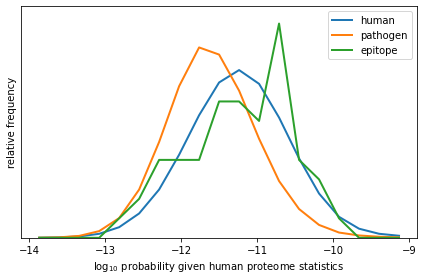

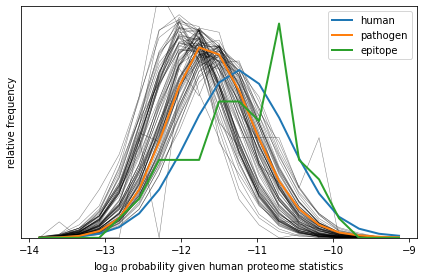

In [30]:
for mhc in [False, True]:
    fig, ax = plt.subplots()
    if mhc:
        plot_histograms(preds,
                        [None]*len(preds),
                        nbins=20, lw=.5, color='k', alpha=.5,
                        xmin=-14, xmax=-9, ax=ax, step=False)
    plot_histograms([phuman, ppathogen, pepitope],
                    ['human', 'pathogen', 'epitope'],
                    nbins=20, lw=2,
                    xmin=-14, xmax=-9, ax=ax, step=False)
    ax.set_ylabel('relative frequency')
    ax.set_ylim(0.0, 0.22)
    ax.set_yticks([])
    ax.set_xlabel('$\log_{10}$ probability given human proteome statistics')
    fig.tight_layout()
    #fig.savefig('plots/likelihoodprofile-Malaria-triplet-k%i%s.png' % (k, '-mhc' if mhc else ''), dpi=300)
    if mhc:
        fig.savefig('main.png')

In [ ]:
dfepi9 = dfepitope[dfepitope['length'] == 9]

In [ ]:
len(set(dfepi9['Description'])), len(set(dfepi9['Description']) - set(dfbinders['Peptide'].unique()))

In [ ]:
with open('peptides.txt', 'w') as f:
    for item in list(dfepi9['Description']):
        f.write("%s\n" % item)

In [32]:
!netMHC peptides.txt -xls -xlsfile peptides.csv -a HLA-A0101 -p 1

# /home/amayer/software/netMHC-4.0//Linux_x86_64/bin/netMHC peptides.txt -xls -xlsfile peptides.csv -a HLA-A0101 -p 1
# Wed Mar 31 15:56:06 2021
# User: amayer
# PWD : /home/amayer/repos/peptidome/code/netmhc
# Host: Linux GEN-AMAYER 5.4.0-70-generic x86_64
# -xls     1                    Save output to xls file
# -xlsfile peptides.csv         File name for xls output
# -a       HLA-A0101            HLA allele name
# -p       1                    Switch on if input is a list of peptides (Peptide format)
# Command line parameters set to:
#	[-a line]            HLA-A0101            HLA allele name
#	[-f filename]                             Input file (by default in FASTA format)
#	[-p]                 1                    Switch on if input is a list of peptides (Peptide format)
#	[-l string]          9                    Peptide length (multiple lengths separated by comma e.g. 8,9,10)
#	[-s]                 0                    Sort output on decreasing affinity
#	[-rth float]         

In [ ]:
pd.read_csv('peptides.csv', sep='\t', skiprows=1)